<a href="https://colab.research.google.com/github/tsachiblau/sparseGANProject/blob/master/GAN_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

setting up

In [0]:
from keras.optimizers import Adam
import numpy as np

#set seed
np.random.seed(10)

#train params
steps_per_epoch = 3750  # batch_size * steps_per_epoch = epoch size (train size)
epochs = 10
optimizer = Adam(0.0002, 0.5)

#gan param
noise_dim = 100

#images params
img_rows, img_cols, channels = 28, 28, 1
batch_size = 16

#sparse params
sparse_dim = img_rows * img_cols * channels
L1_weight = 0.01   # Loss = data_fidelity + L1_weight * L1_norm
max_iter_of_dict = 100

import data set

In [43]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = (x_train.astype(np.float32) - 127.5) / 127.5  # normalize between +1 -1

x_train = x_train.reshape(-1, img_rows*img_cols*channels) # each image as vector

np.random.shuffle(x_train)
print(x_train.shape)

(60000, 784)


*Train* or load sparse dictionary:

In [0]:
import matplotlib.pyplot as plt
from sklearn.decomposition import DictionaryLearning
import pickle
import os.path
from os import path

#dictionary file name
file_path = 'dictionary.pkl'

#check if dictionary exists
if not path.exists(file_path):
  d=DictionaryLearning(n_components=sparse_dim, max_iter=max_iter_of_dict)
  # train dictionary
  d.fit(x_train[1:sparse_dim,:])
  dictionary = d.components_
  print(dictionary.shape)

  with open(file_path, 'wb') as output:
    pickle.dump(d, output, pickle.HIGHEST_PROTOCOL)
  print("created new dictionary")

else:
  with open(file_path, 'rb') as input:
    d = pickle.load(input)
  # print(d)
  print("loaded dictionary")

dictionary_loaded2 = np.transpose(d.components_)
dictionary_loaded2 = np.array(dictionary_loaded2, dtype = np.float32)
print(dictionary_loaded2.shape)


**sanity** check

785


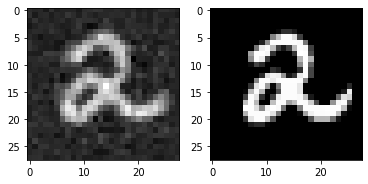

In [39]:
sample_num = np.random.randint(x_train.shape[0])
representation_vec = d.transform(x_train[sample_num:sample_num+1,:])
representation_vec = np.transpose(representation_vec)
print(np.sum(representation_vec.shape))
ans = np.matmul(dictionary_loaded2,representation_vec)
plt.figure()
plt.subplot(121)
plt.imshow(ans.reshape((img_rows, img_cols)), cmap='gray')
plt.subplot(122)
real_im = x_train[sample_num:sample_num+1,:]
plt.imshow(real_im.reshape((img_rows, img_cols)), cmap='gray')


In [0]:
def show_images(noise):
    generated_images = generator.predict(noise)
    generated_images = np.matmul(dictionary_loaded2,np.transpose(generated_images))
    generated_images = np.transpose(generated_images)
    plt.figure(figsize=(10, 10))
    
    for i, image in enumerate(generated_images):
        plt.subplot(10, 10, i+1)
        if channels == 1:
            plt.imshow(image.reshape((img_rows, img_cols)), cmap='gray')
        else:
            plt.imshow(image.reshape((img_rows, img_cols, channels)))
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()


In [0]:
# with pursuit and thresholding approach
# generator:
from keras.models import Sequential
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Input
from keras.models import Model
from keras.initializers import RandomNormal
from keras.layers import Dense, Conv2D, Flatten, Reshape, Dropout, AveragePooling2D, MaxPooling2D, BatchNormalization, Lambda
from tensorflow.linalg import matmul, matrix_transpose

# input: sparse vec size
# output: noise size
def create_reconstructor():
    reconstructor = Sequential()

    #reconstructor.add(Dense(512, input_dim=img_cols*img_rows*channels))
    reconstructor.add(Dense(512, input_dim=sparse_dim))
    reconstructor.add(LeakyReLU(0.2))

    reconstructor.add(Dense(256))
    reconstructor.add(LeakyReLU(0.2))

    reconstructor.add(Dense(noise_dim))
    reconstructor.add(LeakyReLU(0.2))

    #reconstructor.compile(loss='mean_squared_error', optimizer='sgd')
    return reconstructor

# input: noise size
# output: sparse vec size
def create_generator():
    generator = Sequential()
    
    generator.add(Dense(256, input_dim=noise_dim))
    generator.add(BatchNormalization())
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(512))
    generator.add(BatchNormalization())
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(1024))
    generator.add(BatchNormalization())
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(sparse_dim, activation='tanh'))
    return generator

# input: image size
# output: 1 number - 1 real 0 fake
# descriminator:
def create_descriminator():
    discriminator = Sequential()
    #16 - better
    discriminator.add(Conv2D(16, (3, 3), strides=(2,2),padding='same', kernel_initializer=RandomNormal(0, 0.02), input_shape=(img_cols, img_rows, channels)))
    discriminator.add(BatchNormalization())
    discriminator.add(LeakyReLU(0.2))
    #32 - better
    discriminator.add(Conv2D(32, (3, 3), strides=(2,2), padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    discriminator.add(BatchNormalization())
    discriminator.add(LeakyReLU(0.2))
    # 64 - better
    discriminator.add(Conv2D(64, (3, 3), strides=(2,2), padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    discriminator.add(BatchNormalization())
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Flatten())
    discriminator.add(Dropout(0.4))
    discriminator.add(Dense(1, activation='sigmoid'))   # 1 number which indicates real / fake
    
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator

# build GAN
discriminator = create_descriminator()
generator = create_generator()
reconstructor = create_reconstructor()

discriminator.trainable = False   # will be trained separately, not as GAN

gan_input = Input(shape=(noise_dim,))

# G(z) is a sparse vector
sparse_vec = generator(gan_input)   # sparse_dim size

# a layer that creates the multiplication between the sparse tensor with dictionary to create image
fake_image_vec = Lambda(lambda x: matrix_transpose(matmul(dictionary_loaded2,matrix_transpose(x))))(sparse_vec)
# reshape to image size - will be inserted to discriminator
fake_image = Reshape((img_rows, img_cols, channels))(fake_image_vec)

gan_output = discriminator(fake_image)  # the descriminator output
vae_output = reconstructor(sparse_vec)  # the reconstructor output

vae = Model(gan_input, vae_output)
vae.compile(loss='mean_squared_error', optimizer='sgd')

# todo - double output double loss
gan = Model(gan_input, [gan_output,sparse_vec])
gan.compile(loss=['binary_crossentropy','mean_absolute_error'], optimizer=optimizer,loss_weights=[1,L1_weight])



2nd approach train

In [40]:
import matplotlib.pyplot as plt

for epoch in range(epochs):  #epochs
    num_of_non_zeros = 0
    
    for batch in range(steps_per_epoch):  #steps_per_epoch
        noise = np.random.normal(0, 1, size=(batch_size, noise_dim))  # will generate batch amount of noise vectors (gaussian distribution)
        fake_x = generator.predict(noise) # create G(z)
        num_of_non_zeros = num_of_non_zeros + np.sum(fake_x > 0.1)
        # fake is (batch_size,sparse_dim)
        
        fake_x = np.transpose(fake_x)
        # thresholding
        
        # multiply by dict
        fake_x = np.matmul(dictionary_loaded2,fake_x)
        fake_x = np.transpose(fake_x)
        fake_x = fake_x.reshape(batch_size,img_rows,img_cols,channels)
        # fake_x is of size (batch,rows,cols,channels)

        real_x = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)] # sample real image
        #remove below to return to FC scheme
        real_x = real_x.reshape(fake_x.shape)

        x = np.concatenate((real_x, fake_x))
        # x is of size (2*batch,rows,cols,channels)
        
        disc_y = np.zeros(2*batch_size)
        disc_y[:batch_size] = 0.9

        # train_on_batch recieves data and desired output
        d_loss_fake = discriminator.train_on_batch(x[:batch_size], disc_y[:batch_size])
        d_loss_real = discriminator.train_on_batch(x[batch_size:], disc_y[batch_size:])
        
        # train GAN (descriminator weights are fixed)
        y_gen_1 = np.ones(batch_size)
        y_gen_2 = np.zeros(batch_size * sparse_dim)
        y_gen_2 = y_gen_2.reshape(batch_size,sparse_dim)
        # TODO train the two outputs
        g_loss = gan.train_on_batch(noise, [y_gen_1,y_gen_2])

        # train reconstructor
        r_loss = vae.train_on_batch(noise[:batch_size],noise[:batch_size])
        
        

    print(f'Epoch: {epoch + 1} \t Discriminator Loss_fake: {d_loss_fake} \t Discriminator Loss_real: {d_loss_real}\t\t Generator Loss: {g_loss} \t\t Reconstructor Loss: {r_loss} \t\t num_of_non_zeros: {num_of_non_zeros/(steps_per_epoch * batch_size)}')
    
    #show res
    noise = np.random.normal(0, 1, size=(10, noise_dim))
    show_images(noise)



/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


KeyboardInterrupt: ignored

show 100 results

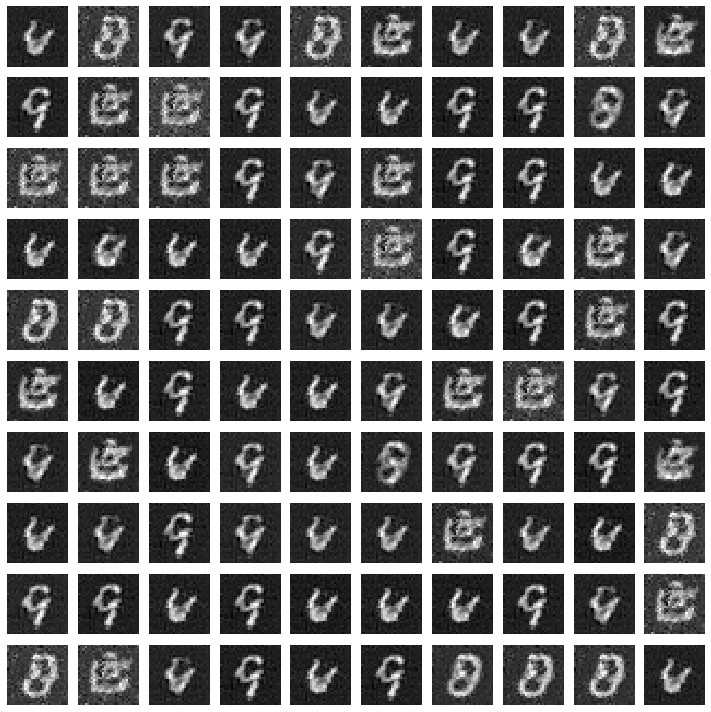

In [30]:
noise = np.random.normal(0, 1, size=(100, noise_dim))
show_images(noise)